In [1]:
import sys
sys.path.insert(0, '../..')

# general
import ast
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

sns.set()
warnings.filterwarnings("ignore")

# local
from sklearn_crfsuite import metrics
from core.stats import Statistics
from core.utils import load_dataset
from core.plots import plot_histogram, plot_learning_curve
from core.learning import LearningAnalyser
from core.reports import (
    compute_user_error,
    generate_comparison_report,
    generate_test_groups_comparison_report,
    generate_learning_report
)
from core.dataset import DatasetAnalyser, DatasetGroup

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score
)

from core.latex import create_latex_tables_generator

import numpy as np
np.random.seed(3453562)

# 1. General statistics
## 1.1. Read data

In [2]:
df = load_dataset('../../data/hotel_review_sentiment/hotel_review_sentiment-dataset.csv')
df['annotation__output'] = df['annotation__output'].apply(lambda x: float(x.split(' - ')[0]))
df['reference__output'] = df['reference__output'].apply(lambda x: float(x.split(' - ')[0]))

## 1.2. Statistics

In [3]:
stats = Statistics(df)

### 1.2.1. General

In [4]:
stats.general

,value
metric,
total_annotations,10378
unique_items,2294
unique_users,182
total_annotation_time,08h 44m 24s


### 1.2.2. Annotations per item

In [5]:
stats.annotations_per_item

,data__item_id
count,2294.000000
mean,4.523976
std,1.890618
min,1.000000
25%,3.000000
50%,4.000000
75%,6.000000
max,12.000000


### 1.2.3. Annotations per user

In [6]:
stats.annotations_per_user

,user__id
count,182.000000
mean,57.021978
std,46.601396
min,11.000000
25%,50.000000
50%,50.000000
75%,50.000000
max,400.000000


### 1.2.4. Average annotation time over time

,value
index,
10,12.019399
20,10.780514
30,10.544166
40,10.949810
60,13.259249
70,9.660688
80,12.217221
90,12.649324


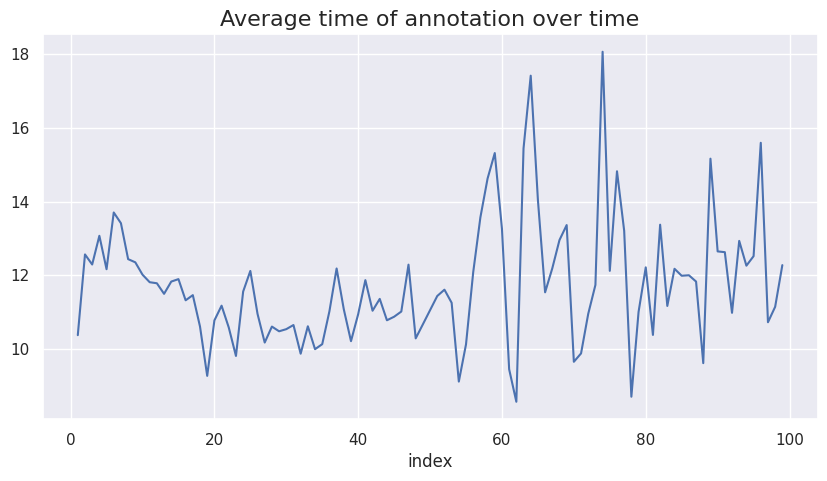

In [7]:
plt.figure(figsize=(10, 5))
plt.title("Average time of annotation over time", fontsize=16)
df_times = stats.average_time_per_annotation
df_times['value'].plot()
df_times[df_times.index % 10 == 0]

# 2. Confidence intervals
## 2.1. Compute user's annotation quality metrics
- In this section we aggregate the raw result to compute the quality metrics value per user
- To measure the quality of user's annotation we use: accuracy, recall, f1 and precision metrics
- Mean error is computed for each user in each test_group separately.<br/>
This way we can check how each user did in each test conditions

In [8]:
METRICS_COLUMNS = ["me", "mae", "mse", "accuracy", "annotation_time", "count"]

In [9]:
def metrics_function(y_true: pd.Series, y_pred: pd.Series):
    return {
        "mae": (y_true - y_pred).abs().mean(),
        "mse": (y_true - y_pred).pow(2).mean(),
        "me": (y_true - y_pred).mean(),
        "accuracy": (y_true == y_pred).mean()
    }
  
    
df_user_error = compute_user_error(df, metrics_function)

## 2.2. Compute confidence intervals for test groups
In this section we compute the confidence intervals for the percentage quality change between the control group and each of the test groups.

In [10]:
dataset = DatasetAnalyser(df_user_error, METRICS_COLUMNS)

### 2.2.1. Compering: test groups vs control group

In [11]:
df_ci_h1, df_percentage_ci_h1, df_p_value_h1, df_cohen_d_h1 = generate_comparison_report(dataset)

#### Confidence intervals

In [12]:
df_ci_h1

me       mae       mse  accuracy  \
group_name              quantile                                           
high quality feedback   0.05     -0.082545 -0.096843 -0.337405 -0.050803   
                        0.5       0.046682  0.008601  0.014510 -0.013820   
                        0.95      0.171834  0.119713  0.382915  0.022160   
low quality feedback    0.05     -0.492634  0.067415  0.017777 -0.130504   
                        0.5      -0.204422  0.209678  0.513993 -0.084134   
                        0.95      0.071540  0.345683  1.007696 -0.035366   
medium quality feedback 0.05     -0.059381 -0.226558 -0.709714 -0.002003   
                        0.5       0.152150 -0.094454 -0.270649  0.054241   
                        0.95      0.378690  0.050617  0.181942  0.107946   

                                  annotation_time      count  
group_name              quantile                              
high quality feedback   0.05            -0.165541 -10.255755  
                        0.5              1.879663  -4.977900  
                        0.95             3.903281   0.387984  
low quality feedback    0.05            -6.060668  -9.960217  
                        0.5             -1.229001  12.113189  
                        0.95             3.545873  34.979567  
medium quality feedback 0.05            -5.207050 -44.754915  
                        0.5             -1.320827  -0.960769  
                        0.95             2.600194  35.661966

#### Percentage confidence intervals

In [13]:
df_percentage_ci_h1

me       mae       mse  accuracy  \
group_name              quantile                                            
high quality feedback   0.05       0.303760 -0.076228 -0.120835 -0.185497   
                        0.5       -0.171787  0.006770  0.005196 -0.050463   
                        0.95      -0.632339  0.094230  0.137134  0.080914   
low quality feedback    0.05      10.694983  0.051557  0.005579 -0.397697   
                        0.5        4.437964  0.160356  0.161297 -0.256388   
                        0.95      -1.553115  0.264369  0.316226 -0.107775   
medium quality feedback 0.05       0.207723 -0.170999 -0.239484 -0.007964   
                        0.5       -0.532245 -0.071291 -0.091327  0.215646   
                        0.95      -1.324721  0.038204  0.061394  0.429163   

                                  annotation_time     count  
group_name              quantile                             
high quality feedback   0.05            -0.017422 -0.188267  
                        0.5              0.197818 -0.091380  
                        0.95             0.410787  0.007122  
low quality feedback    0.05            -0.390031 -0.204251  
                        0.5             -0.079092  0.248401  
                        0.95             0.228193  0.717313  
medium quality feedback 0.05            -0.332000 -0.752183  
                        0.5             -0.084216 -0.016147  
                        0.95             0.165788  0.599361

#### p-value

In [14]:
df_p_value_h1

,me,mae,mse,accuracy,annotation_time,count,group_name
0,0.7272,0.5430,0.5212,0.2720,0.9336,0.0671,high quality feedback
0,0.1076,0.9875,0.9550,0.0079,0.3402,0.8074,low quality feedback
0,0.8763,0.1360,0.1668,0.9437,0.2848,0.5181,medium quality feedback


#### Cohen's D

In [15]:
df_cohen_d_h1

,me,mae,mse,accuracy,annotation_time,count,group_name
0,0.108704,0.024771,0.012550,-0.117281,0.256503,-0.267847,high quality feedback
0,-0.370090,0.820734,0.543679,-0.998730,-0.139428,0.273119,low quality feedback
0,0.344687,-0.360832,-0.298651,0.540963,-0.173043,-0.014247,medium quality feedback


#### Ploting histograms for the difference: test groups vs control group

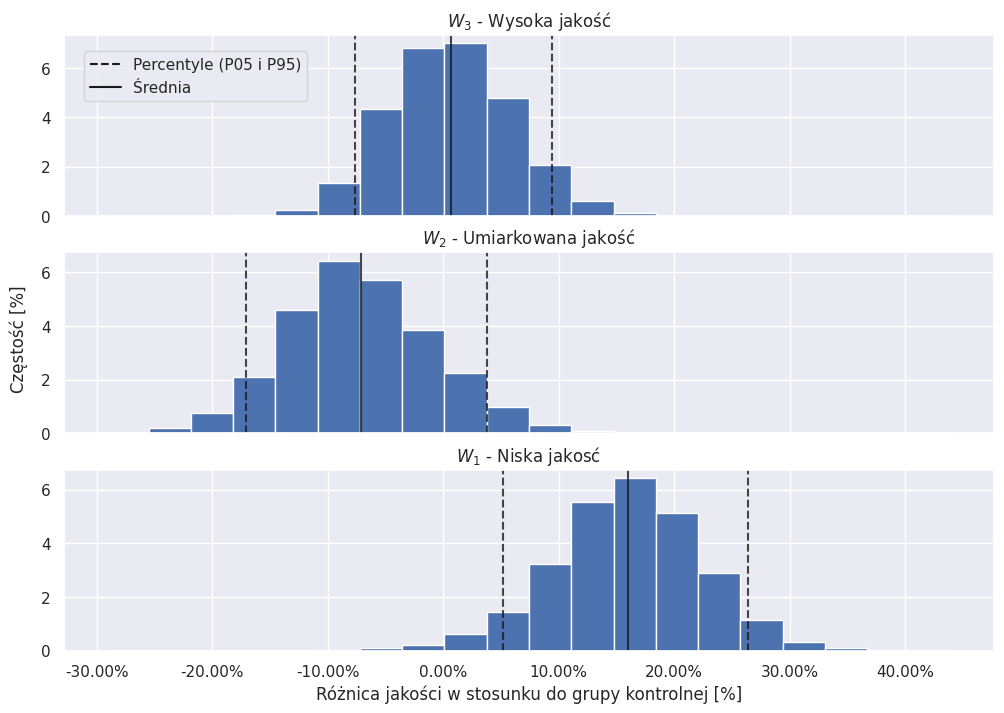

In [16]:
metric_index = 1
plot_histogram(dataset, metric_index)

### 2.2.2. Comparing: test groups with each other

In [17]:
df_ci_h2, df_p_value_h2, df_cohen_d_h2 = generate_test_groups_comparison_report(dataset)

#### Confidence interval

In [18]:
df_ci_h2

me       mae       mse  accuracy  \
group_name  quantile                                            
high_low    0.05     -10.890416 -0.292340 -0.358831  0.009183   
            0.5       -4.609751 -0.153586 -0.156100  0.205925   
            0.95       1.381988 -0.014917  0.048586  0.405187   
high_medium 0.05      -0.495516 -0.056718 -0.092414 -0.506562   
            0.5        0.360458  0.078061  0.096523 -0.266109   
            0.95       1.223848  0.194890  0.276395 -0.010077   
medium_low  0.05     -11.325412 -0.375696 -0.460126  0.196697   
            0.5       -4.970208 -0.231647 -0.252624  0.472034   
            0.95       1.096111 -0.086060 -0.045044  0.750776   

                      annotation_time     count  
group_name  quantile                             
high_low    0.05            -0.086747 -0.821833  
            0.5              0.276910 -0.339781  
            0.95             0.630212  0.140472  
high_medium 0.05            -0.052932 -0.697190  
            0.5              0.282034 -0.075233  
            0.95             0.606278  0.670817  
medium_low  0.05            -0.416888 -1.098920  
            0.5             -0.005124 -0.264548  
            0.95             0.393361  0.519875

#### p-value

In [19]:
df_p_value_h2

,me,mae,mse,accuracy,annotation_time,count,group_name
0,0.0983,0.0343,0.1081,0.9561,0.8913,0.1214,high_low
0,0.7519,0.8467,0.8089,0.0437,0.9189,0.4003,high_medium
0,0.0854,0.0061,0.0200,0.9959,0.4937,0.3018,medium_low


#### Cohen's D

In [20]:
df_cohen_d_h2

,me,mae,mse,accuracy,annotation_time,count,group_name
0,-1.760743,-2.591541,-1.793219,2.404258,1.696036,-1.675504,high_low
0,0.935294,1.345994,1.124711,-2.418440,1.985263,-0.258645,high_medium
0,-1.889331,-3.595436,-2.695024,4.157954,-0.029629,-0.756921,medium_low


# 3. Analyse learning curve

In [21]:
df['annotation_eval'] = (df['reference__output'] == df['annotation__output']).astype(int)
df_high = df.query("test_group == 'high quality feedback'")

In [22]:
learning = LearningAnalyser(df_high)

#### Learning curve stats

In [23]:
learning_report = generate_learning_report(learning)
learning_report

,Metryka,Wartość
0,$\alpha$,-0.0
1,$\beta$,0.008
2,$\alpha_r$,-6.30%
3,$\beta_r$,+3.15%


#### Learning curve plot

In [24]:
# styling fix
learning_report['Wartość'] = learning_report['Wartość'].astype(str).str.replace(".", ",")

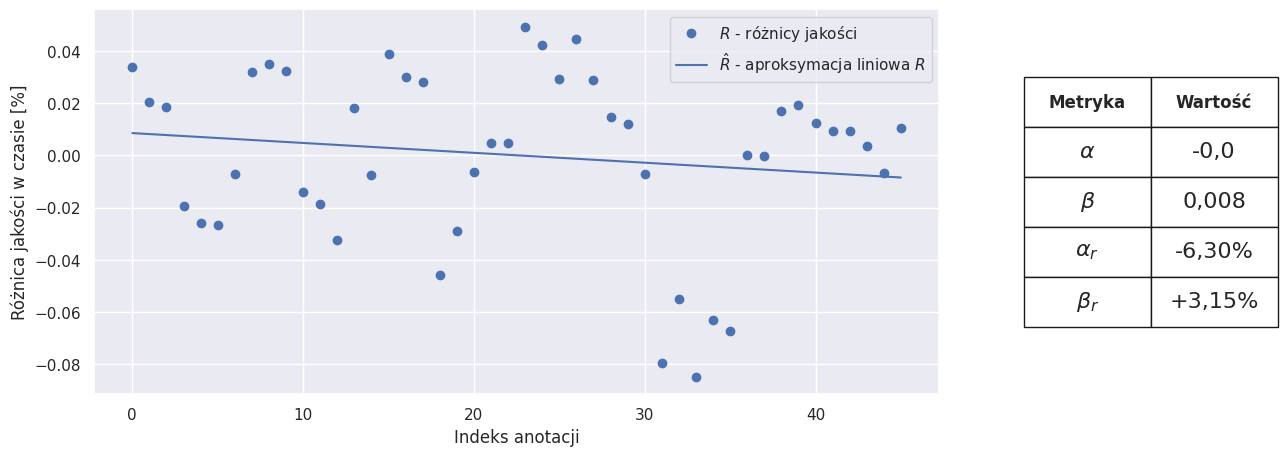

In [25]:
plot_learning_curve(learning, learning_report)

## Generate latex tables

In [26]:
latex_generator = create_latex_tables_generator(
    df_percentage_ci_h1=df_percentage_ci_h1,
    df_p_value_h1=df_p_value_h1,
    df_cohen_d_h1=df_cohen_d_h1,
    df_ci_h2=df_ci_h2,
    df_p_value_h2=df_p_value_h2,
    df_cohen_d_h2=df_cohen_d_h2
)

In [27]:
print(latex_generator.get_results_table("mae"))


\begin{table}[H]
\centering
\caption{}
\label{tab:my-table}
\begin{tabular}{cccccc}
\rowcolor[HTML]{EFEFEF} 
\multicolumn{1}{c|}{\cellcolor[HTML]{EFEFEF}\textbf{Warunek}} &
  \multicolumn{1}{c|}{\cellcolor[HTML]{EFEFEF}\boldmath$P_{05}$} &
  \multicolumn{1}{c|}{\cellcolor[HTML]{EFEFEF}\boldmath$\mu$} &
  \multicolumn{1}{c|}{\cellcolor[HTML]{EFEFEF}\boldmath$P_{95}$} &
  \multicolumn{1}{c|}{\cellcolor[HTML]{EFEFEF}\boldmath$p$} &
  \boldmath$d$ \\ \hline
\rowcolor[HTML]{EFEFEF} 
\multicolumn{6}{c}{\cellcolor[HTML]{EFEFEF}Hipoteza $H_1$ -- zmiana w metryce XXXX}                                                                                                        \\ \hline
        \multicolumn{1}{c|}{$W_1$} & \multicolumn{1}{c|}{-7.62\%} & \multicolumn{1}{c|}{+0.68\%} & \multicolumn{1}{c|}{+9.42\%} & \multicolumn{1}{c|}{0.543} & 0.02 \\ \hline\multicolumn{1}{c|}{$W_2$} & \multicolumn{1}{c|}{-17.10\%} & \multicolumn{1}{c|}{-7.13\%} & \multicolumn{1}{c|}{+3.82\%} & \multicolumn{1}{c|}{0.1